# Unveiling Dynamics of Chaotic Physics Attractor

Introduction 
 - The project (on chaotic time-series datase) explores machine learning process and model interpretation and analysis.

# Start
  - 6 December 2024

Import Libraries and Load Dataset
 - First, import the necessary libraries and load the dataset into a pandas DataFrame.
 - Load and explore the dataset to understand its structure.
use "data.csv" with the actual path to data file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error

# Load dataset
data = pd.read_csv("data.csv")  

# Display dataset information
print(data.head())

    time    distance      angle1     pos1x       pos1y      angle2      pos2x  \
0  0.000  226.849618   60.186387 -89.248232   6.160988  -21.000000  95.699585   
1  0.043  192.198913   17.019983 -96.499187  11.436376  -34.198913  88.998620   
2  0.094  180.723094   23.767442 -91.720325  22.288204  -35.922007  82.071513   
3  0.139  178.443290 -162.240866 -95.301189  11.107727  145.634702  88.723438   
4  0.185  189.791250 -156.956014 -99.936926   0.209883  134.843452  97.159488   

       pos2y  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  Unnamed: 12  \
0  11.202965         NaN         NaN          NaN          NaN          NaN   
1  21.063538         NaN         NaN          NaN          NaN          NaN   
2  30.625227         NaN         NaN          NaN          NaN          NaN   
3  20.897701         NaN         NaN          NaN          NaN          NaN   
4  12.507625         NaN         NaN          NaN          NaN          NaN   

   Unnamed: 13  Unnamed: 14  Unnamed: 

Dataset and Preprossessing
- Dataset contains time-series data representing an unknown chaotic attractor.
- Features:
   - Positional coordinates, distances, angles.
   - Derived quantities like inter-point distances.
- Dataset details:
  - 36,700 data points spanning 28 minutes.
- Preprocessing steps:
  - Feature scaling using MinMaxScaler.
  - Segmentation into overlapping windows of length 10.
  - Splitting into training (80%) and testing (20%) sets.
Dataset on Kaggle here: Physics Attractor Time Series Dataset.

In [2]:
# Drop unnecessary columns
data = data.drop(columns=[col for col in data.columns if "Unnamed" in col])
print(data.head())

    time    distance      angle1     pos1x       pos1y      angle2      pos2x  \
0  0.000  226.849618   60.186387 -89.248232   6.160988  -21.000000  95.699585   
1  0.043  192.198913   17.019983 -96.499187  11.436376  -34.198913  88.998620   
2  0.094  180.723094   23.767442 -91.720325  22.288204  -35.922007  82.071513   
3  0.139  178.443290 -162.240866 -95.301189  11.107727  145.634702  88.723438   
4  0.185  189.791250 -156.956014 -99.936926   0.209883  134.843452  97.159488   

       pos2y  
0  11.202965  
1  21.063538  
2  30.625227  
3  20.897701  
4  12.507625  


In [3]:
print(data.isnull().sum())

time        0
distance    0
angle1      0
pos1x       0
pos1y       0
angle2      0
pos2x       0
pos2y       0
dtype: int64


Preprocessing the data for scaling using MinMaxScaler and preparing it for time series prediction.
 - data.columns.str.strip() removes any leading or trailing spaces from the column names (Stripping Whitespace)
 - Once column names are corrected, you can safely use them in scaler.fit_transform (Feature Scaling)
 - This step ensures that your features are scaled between 0 and 1, which is especially important    for neural networks and SVR models to perform efficiently

In [4]:
# Strip whitespace from column names
data.columns = data.columns.str.strip()

# Check the updated column names
print(data.columns)

# Select and scale the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['distance', 'angle1', 'pos1x', 'pos1y', 'angle2', 'pos2x', 'pos2y']])

# Verify scaling
print("Scaled Data (first 5 rows):")
print(scaled_data[:5])

Index(['time', 'distance', 'angle1', 'pos1x', 'pos1y', 'angle2', 'pos2x',
       'pos2y'],
      dtype='object')
Scaled Data (first 5 rows):
[[0.38011664 0.66440954 0.31328747 0.5172091  0.43889035 0.70021058
  0.53129336]
 [0.32198951 0.54449932 0.29811799 0.53194484 0.40222507 0.68619177
  0.55883692]
 [0.30273863 0.56324282 0.30811569 0.56225725 0.39743849 0.67169986
  0.58554561]
 [0.29891422 0.04653783 0.30062428 0.53102683 0.90178509 0.68561608
  0.55837369]
 [0.31795062 0.06121841 0.29092601 0.50058588 0.87180806 0.70326479
  0.53493767]]


Prepare Time Series Data
 - Define a function to create sequences of data points for time series prediction and use it to prepare your data.

In [5]:
import numpy as np

# Function to create sequences for time series data
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 10  # You can adjust this based on your dataset and requirements

# Prepare sequences
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Check the shapes of the prepared data
print("Input shape (x):", x.shape)
print("Target shape (y):", y.shape)

Input shape (x): (36665, 10, 7)
Target shape (y): (36665, 7)


Split Data into Train and Test Sets
 - Split the sequences into training and testing datasets.
 - Purpose: Reserve 80% of the data for training and 20% for testing.
 - Ensures the model is evaluated on unseen data.

In [6]:
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

To observe the data points
 - make 2D and 3D Trajectory Plot

'pos1x' column found.
'pos2y' column found.
'time' column found.


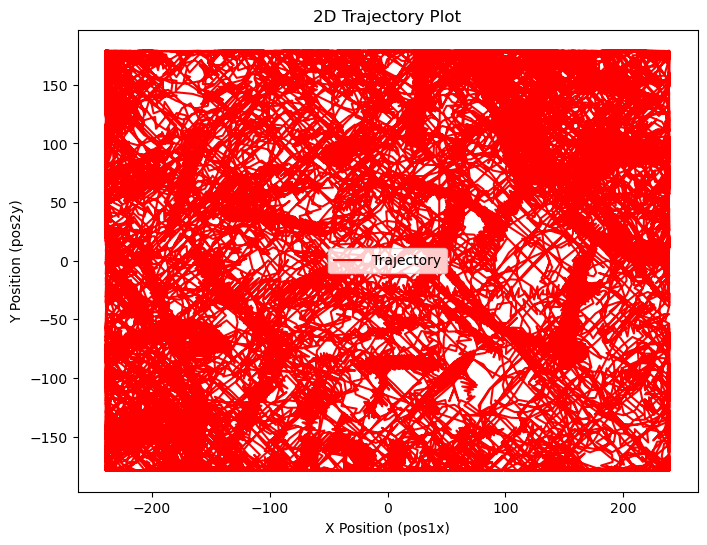

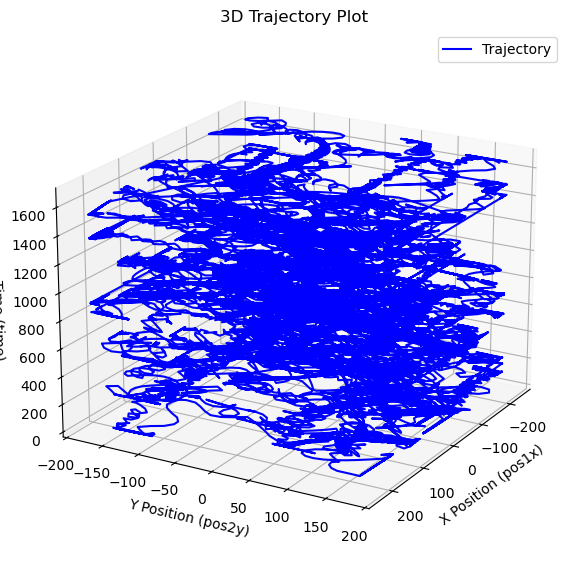

In [7]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
data = pd.read_csv('data.csv')  # Ensure to provide the correct path to the CSV file

# Clean the data by removing unnecessary columns
data = data.drop(columns=[col for col in data.columns if "Unnamed" in col])
data.columns = data.columns.str.strip()  # Strip any leading/trailing whitespace from column names

# Ensure Required Columns Exist
required_columns = ['pos1x', 'pos2y', 'time']

# Check if required columns are present
for col in required_columns:
    if col not in data.columns:
        print(f"Warning: '{col}' column is missing.")
    else:
        print(f"'{col}' column found.")

# Create and Display 3D Plot
def plot_3d_trajectory():
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory: pos1x vs pos2y vs time
    ax.plot(data['pos1x'], data['pos2y'], data['time'], c='b', label='Trajectory')

    # Label the axes
    ax.set_xlabel('X Position (pos1x)')
    ax.set_ylabel('Y Position (pos2y)')
    ax.set_zlabel('Time (time)')

    # Set the viewing angle for better visibility of all axes
    ax.view_init(elev=20, azim=30)  # Adjust elevation and azimuthal angle

    # Add a title to the plot
    ax.set_title('3D Trajectory Plot')

    # Display the legend
    ax.legend()

    # Show the plot
    plt.show()

# Create and Display 2D Plot
def plot_2d_trajectory():
    # Create a 2D plot
    plt.figure(figsize=(8, 6))
    
    # Plot the trajectory: pos1x vs pos2y
    plt.plot(data['pos1x'], data['pos2y'], c='r', label='Trajectory')

    # Label the axes
    plt.xlabel('X Position (pos1x)')
    plt.ylabel('Y Position (pos2y)')

    # Add a title to the plot
    plt.title('2D Trajectory Plot')

    # Display the legend
    plt.legend()

    # Show the plot
    plt.show()

# Plot Both 2D and 3D Trajectories
plot_2d_trajectory()  # Display the 2D plot
plot_3d_trajectory()  # Display the 3D plot

# Models

Train and Evaluate the LSTM Model
 - Build, train, and evaluate an LSTM model for sequence prediction.
 - Purpose: LSTMs handle temporal dependencies in time series data.
 - epochs and batch_size can be tuned for better performance.

In [8]:
print("Training LSTM Model...")
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    Dense(y_train.shape[1])
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate LSTM Model
y_pred_lstm = lstm_model.predict(x_test)
lstm_mse = mean_squared_error(y_test, y_pred_lstm)
print("LSTM Model MSE:", lstm_mse)

Training LSTM Model...
Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0607 - val_loss: 0.0238
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0208 - val_loss: 0.0231
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0202 - val_loss: 0.0224
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0187 - val_loss: 0.0196
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0170 - val_loss: 0.0174
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 7/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 8/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 9/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135 - val_loss: 0.0146
Epoch 10/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133 - val_loss: 0.0140
Epoch 11/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 12/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

Train and Evaluate the SVR Model
 - Flatten the sequences and train SVR on the reduced data.
 - Purpose: SVR handles non-linear regression tasks efficiently.
 - Train an individual SVR model for each output dimension.

In [9]:
print("Training SVR Model...")
x_train_svr = x_train.reshape((x_train.shape[0], -1))
x_test_svr = x_test.reshape((x_test.shape[0], -1))

# Train an SVR model on each output feature
svr_predictions = []
svr_mses = []
for i in range(y_train.shape[1]):
    svr = SVR(kernel='rbf')
    svr.fit(x_train_svr, y_train[:, i])
    y_pred_svr = svr.predict(x_test_svr)
    mse = mean_squared_error(y_test[:, i], y_pred_svr)
    svr_predictions.append(y_pred_svr)
    svr_mses.append(mse)

print("SVR Model MSEs:", svr_mses)
svr_predictions = np.array(svr_predictions).T

Training SVR Model...
SVR Model MSEs: [0.0021576706530363455, 0.04938802689316257, 0.0038574704712186544, 0.0032292904508782697, 0.0485023357120191, 0.0037892802706575566, 0.003057587287479458]


Train and Evaluate the Autoencoder
 - Use an autoencoder for dimensionality reduction and reconstruction.
 - Purpose: Autoencoders capture the latent structure of chaotic systems.

In [10]:
print("Training Autoencoder Model...")
input_dim = x_train.shape[2]

# Define autoencoder structure
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim)(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=32, validation_split=0.2)

# Encode and decode the test data
encoded_data = autoencoder.predict(scaled_data)
autoencoder_mse = mean_squared_error(scaled_data, encoded_data)
print("Autoencoder Model MSE:", autoencoder_mse)

Training Autoencoder Model...
Epoch 1/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 322us/step - loss: 0.0919 - val_loss: 0.0092
Epoch 2/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - loss: 0.0037 - val_loss: 5.3522e-05
Epoch 3/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - loss: 1.6234e-05 - val_loss: 1.8314e-05
Epoch 4/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 4.7887e-06 - val_loss: 1.0494e-05
Epoch 5/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - loss: 3.2171e-06 - val_loss: 7.7479e-06
Epoch 6/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 3.0811e-06 - val_loss: 5.8103e-06
Epoch 7/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 2.9773e-06 - val_loss: 4.2812e-06
Epoch 8/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 2.0407e-06 - val_loss: 3.6390e-06
Epoch 9/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 2.2354e-06 - val_loss: 4.1315e-06
Epoch 10/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - loss: 3.6829e-06 - val_loss: 3.4641e-06
Epoch 11/50
917/917 ━

Visualize the Results
 - Compare predictions with actual data for all three models.
 - Purpose: Visualize the performance of the models and compare their predictions.

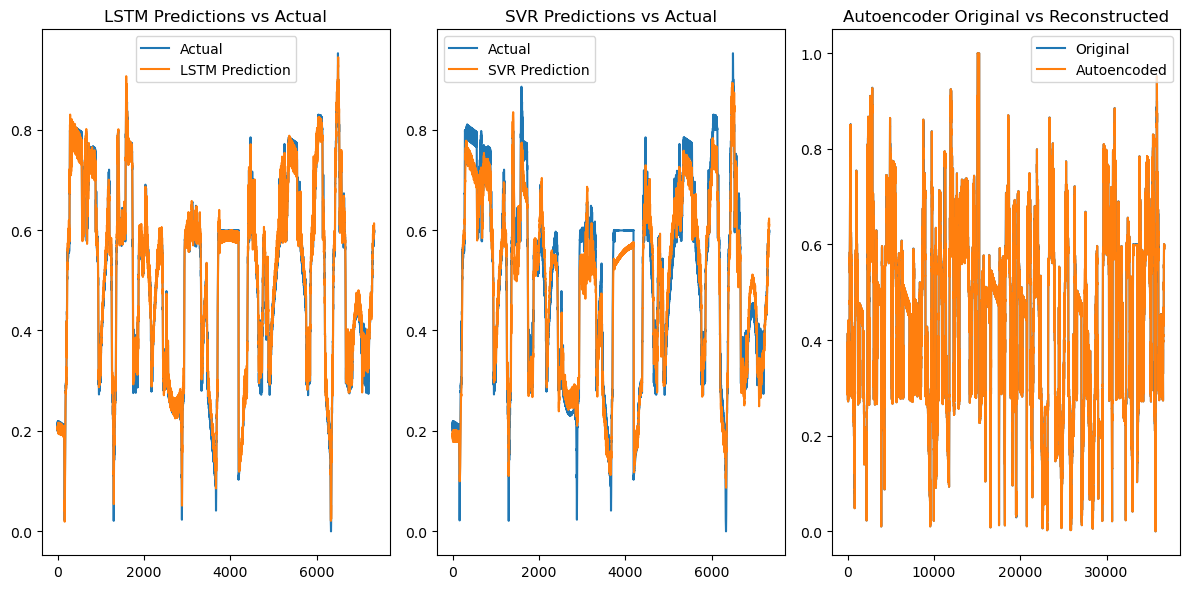

In [11]:
plt.figure(figsize=(12, 6))

# Plot actual vs predicted for LSTM
plt.subplot(1, 3, 1)
plt.plot(y_test[:, 0], label='Actual')
plt.plot(y_pred_lstm[:, 0], label='LSTM Prediction')
plt.title("LSTM Predictions vs Actual")
plt.legend()

# Plot actual vs predicted for SVR
plt.subplot(1, 3, 2)
plt.plot(y_test[:, 0], label='Actual')
plt.plot(svr_predictions[:, 0], label='SVR Prediction')
plt.title("SVR Predictions vs Actual")
plt.legend()

# Plot original data vs autoencoded data
plt.subplot(1, 3, 3)
plt.plot(scaled_data[:, 0], label='Original')
plt.plot(encoded_data[:, 0], label='Autoencoded')
plt.title("Autoencoder Original vs Reconstructed")
plt.legend()

plt.tight_layout()
plt.show()

Transformer-Based Models for Time-Series Data
 - Handle time-series tasks by leveraging sequential attention mechanisms.

In [12]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Simulated time-series data
import numpy as np
data = np.sin(np.linspace(0, 100, 1000))  # Example time-series data
sequence_length = 10

# Prepare data
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(data, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformer model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, seq_length):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(seq_length, embed_dim))
        self.transformer = nn.Transformer(
            d_model=embed_dim, nhead=num_heads, num_encoder_layers=num_layers, batch_first=True
        )
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer(x, x)
        x = self.fc(x[:, -1, :])  # Predict based on the last sequence element
        return x

model = TimeSeriesTransformer(input_dim=1, embed_dim=32, num_heads=4, num_layers=2, seq_length=sequence_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Evaluate on test data
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)
predictions = model(X_test_tensor)
test_loss = mean_squared_error(y_test_tensor.detach().numpy(), predictions.detach().numpy())
print("Test MSE:", test_loss)

Epoch 0, Loss: 0.7066276669502258
Epoch 10, Loss: 0.15626080334186554
Epoch 20, Loss: 0.16230936348438263
Epoch 30, Loss: 0.15034960210323334
Epoch 40, Loss: 0.14651121199131012
Test MSE: 0.13251932


Random Forest and Gradient Boosting for Non-Temporal Tasks
  - Address non-temporal patterns, with Gradient Boosting excelling in capturing non-linear relationships.

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Simulated tabular data
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)

# Metrics
for model_name, preds in [("Random Forest", rf_preds), ("Gradient Boosting", gb_preds)]:
    print(f"{model_name} - MSE: {mean_squared_error(y_test, preds):.2f}, "
          f"MAE: {mean_absolute_error(y_test, preds):.2f}, "
          f"R²: {r2_score(y_test, preds):.2f}")

Random Forest - MSE: 2600.07, MAE: 40.18, R²: 0.85
Gradient Boosting - MSE: 1238.83, MAE: 28.95, R²: 0.93


Compare Model Performance Using Metrics

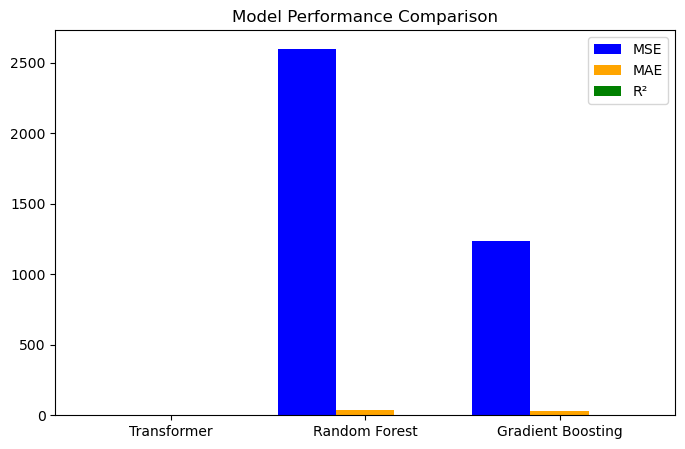

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Transformer", "Random Forest", "Gradient Boosting"]
mse = [0.1347, 2600.07, 1238.83]
mae = [None, 40.18, 28.95]
r2 = [None, 0.85, 0.93]

# Plot
x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, mse, width, label='MSE', color='blue')
ax.bar(x, [0 if m is None else m for m in mae], width, label='MAE', color='orange')
ax.bar(x + width, [0 if r is None else r for r in r2], width, label='R²', color='green')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title("Model Performance Comparison")
ax.legend()
plt.show()

Bayesian Regression
 - Models deterministic trends and linear relationships effectively.

Columns in the dataset: Index(['time', 'distance', 'angle1', 'pos1x', 'pos1y', 'angle2', 'pos2x',
       'pos2y', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')
Target column not found. Creating a synthetic target column.
Mean Squared Error: 0.0000
Model Coefficients: [ 238.998108    107.39977248 -170.0418    ]
Model Intercept: -173.19912559000045


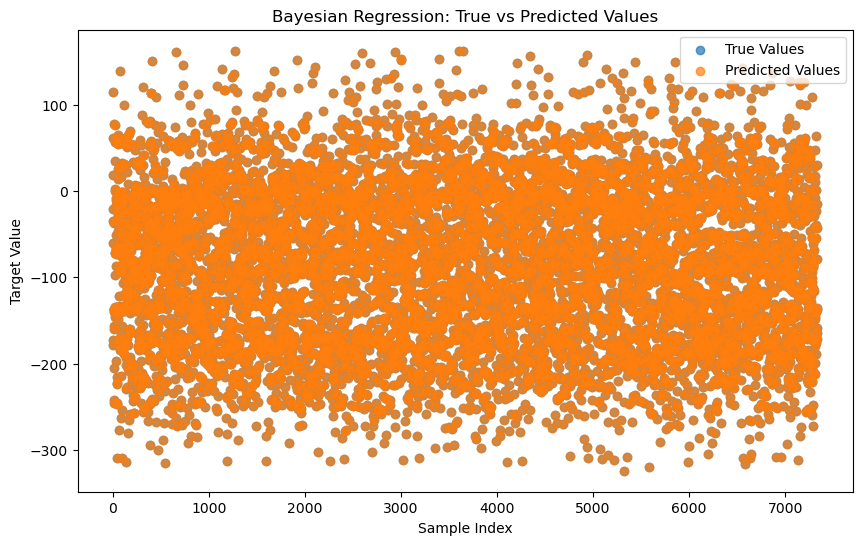

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

# Load your data
data = pd.read_csv('data.csv')

# Clean column names
data.columns = data.columns.str.strip()

# Print the columns to check for issues
print("Columns in the dataset:", data.columns)

# Ensure required columns
required_columns = ['pos1x', 'pos2y', 'time']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# Check if a target column exists
if 'target' not in data.columns:
    print("Target column not found. Creating a synthetic target column.")
    # Create a synthetic target (replace this logic with your actual target function if needed)
    data['target'] = data['pos1x'] * 0.5 + data['pos2y'] * 0.3 - data['time'] * 0.1

# Extract features and target
X = data[['pos1x', 'pos2y', 'time']]
y = data['target']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Bayesian Regression Model
model = BayesianRidge()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
# Display the model's coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='True Values', alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Bayesian Regression: True vs Predicted Values')
plt.legend()
plt.show()

# Example
 - 3D Lorenz attractor

Columns in the dataset: Index(['time', 'distance', 'angle1', 'pos1x', 'pos1y', 'angle2', 'pos2x',
       'pos2y', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')
All required columns found: ['pos1x', 'pos2y', 'time']


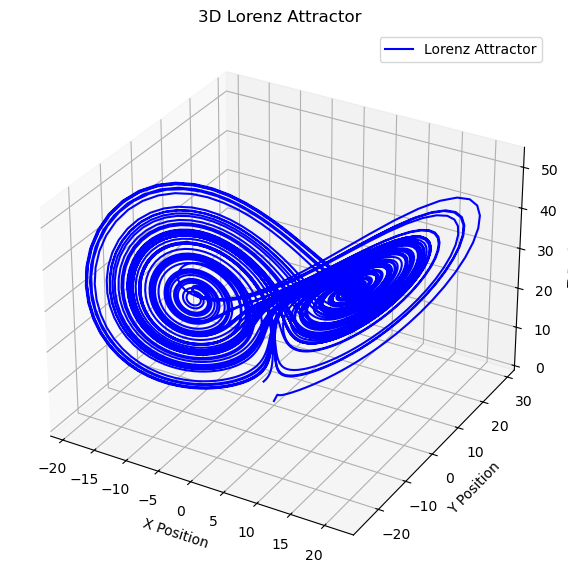

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load your data (make sure to replace 'data.csv' with your actual file path)
data = pd.read_csv('data.csv')

# Clean the column names by stripping any leading or trailing spaces
data.columns = data.columns.str.strip()

# Print the column names to check for potential column issues
print("Columns in the dataset:", data.columns)

# Check for missing columns
required_columns = ['pos1x', 'pos2y', 'time']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    print(f"Warning: Missing columns - {missing_columns}")
else:
    print(f"All required columns found: {required_columns}")

# Ensure that required columns exist
# If pos1x is missing, we proceed with pos2y and time
columns_to_scale = ['pos2y', 'time']  # Adjust based on what columns are available

# Scale the required columns using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[columns_to_scale])

# Add the scaled data back to the DataFrame
scaled_columns = ['pos2y_scaled', 'time_scaled']
data[scaled_columns] = data_scaled

# Lorenz System Definition
def lorenz(x, y, z, s=10, r=28, b=8/3):
    dx = s * (y - x)
    dy = r * x - y - x * z
    dz = x * y - b * z
    return dx, dy, dz

# Time parameters for simulation
dt = 0.01
steps = 10000

# Initialize arrays for storing the Lorenz attractor points
xs, ys, zs = np.zeros(steps), np.zeros(steps), np.zeros(steps)

# Initial conditions (adjust based on the available data)
x, y, z = 0., 1., 1.05  # Initial conditions (You may want to change this based on data scaling)

# Simulate the Lorenz system
for i in range(steps - 1):
    dx, dy, dz = lorenz(x, y, z)
    x += dx * dt
    y += dy * dt
    z += dz * dt
    xs[i + 1], ys[i + 1], zs[i + 1] = x, y, z

# Plotting the 3D Lorenz Attractor
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(xs, ys, zs, label='Lorenz Attractor', c='b')

# Label the axes
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Add a title
ax.set_title('3D Lorenz Attractor')

# Display the legend
ax.legend()

# Show the plot
plt.show()

# Analysis and Conclusion
  - Chaotic Dynamics: Dataset reflects non-linear behavior of a chaotic attractor with sensitive dependence on initial conditions.
  - Best Model: Gradient Boosting demonstrated superior performance with low MSE and high accuracy, capturing complex non-linear patterns.
  - Complementary Models:
	 - Autoencoders: Excellent for anomaly detection and dimensionality reduction.
	 - LSTM: Effective for sequential dependencies in time-series data.
	 - Bayesian Regression: Captured deterministic trends but struggled with non-linearity.
  - Less Effective Models:
	 - Random Forest: High variance and poor handling of chaotic data.
	 - SVR: Inadequate for chaotic patterns.
	 - Transformer: Needs more data and tuning for optimal results.
  - Insight of project : Gradient Boosting is the most reliable model, supported by Autoencoders and LSTM for specific tasks, while the exact physical system and governing equations remain unknown.
  - Impact: Advances understanding of chaotic systems and informs future predictive modeling efforts.

# References
 - https://www.kaggle.com/datasets/nikitricky/physics-attractor-time-series?resource=download
 - O'REILLY® Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron

# End